In [13]:
dir_data = "dataset1"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"


In [14]:
## visualizing a signle segmentation image

### In this data, there are 12 segmentation classes and the image is from a driving car

In [3]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


##seaborn has a white frid by default so I/ will get rid of this.
sns.set_style("whitegrid", {'axes.grid': False})
ldseg = np.array(os.listdir(dir_seg))
#print(ldseg.shape)
#print(ldseg)
fnm = ldseg[0]
print(fnm)

#read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm)    #(360,  480, 3)

img_is = cv2.imread(dir_img + fnm)

print("seg.shape  = {}, img_is.shape = {}".format(seg.shape, img_is.shape))

##check the number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma-mi+1

print("minimum seg = {}, maximum seg = {}, total segmentation classes= {}".format(mi, ma, n_classes))


fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize = (15, 10))
for k in range(mi, ma+1):
    ax = fig.add_subplot(3, n_classes/3, k+1)
    ax.imshow((seg ==k)*1.0)
    ax.set_title("label = {}".format(k))
    
plt.show()

0001TP_006690.png
seg.shape  = (360, 480, 3), img_is.shape = (360, 480, 3)
minimum seg = 0, maximum seg = 11, total segmentation classes= 12


<Figure size 500x500 with 1 Axes>

<Figure size 1500x1000 with 12 Axes>

In [5]:
## Data preprocessing: Resize image

#to simplify the problem, I will reshape all the images to the image size: (224, 224). This is the image shape 
#used in VGG and FCN model. The FCN model becomes easier to explain when the image shape is (224, 224).
#However, FCN does not require the image shape to be (224, 224).

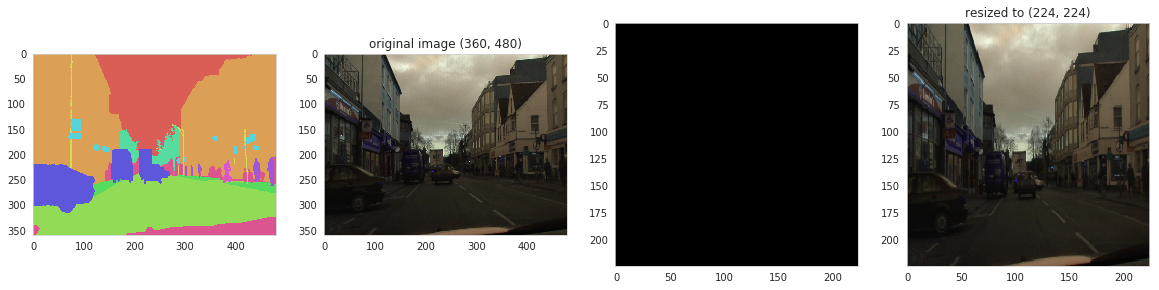

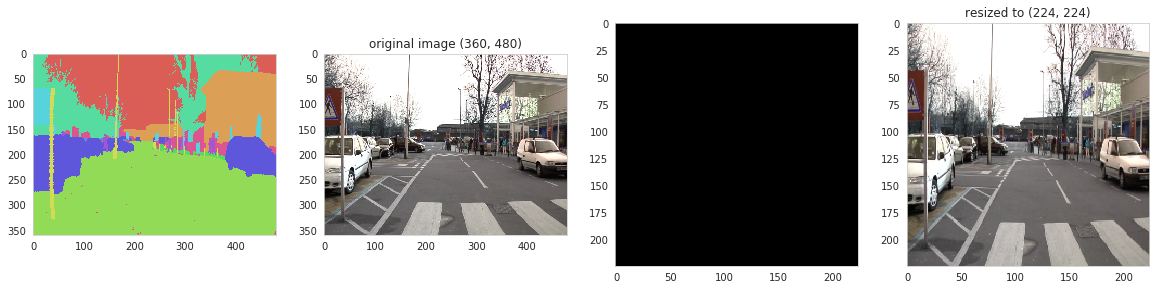

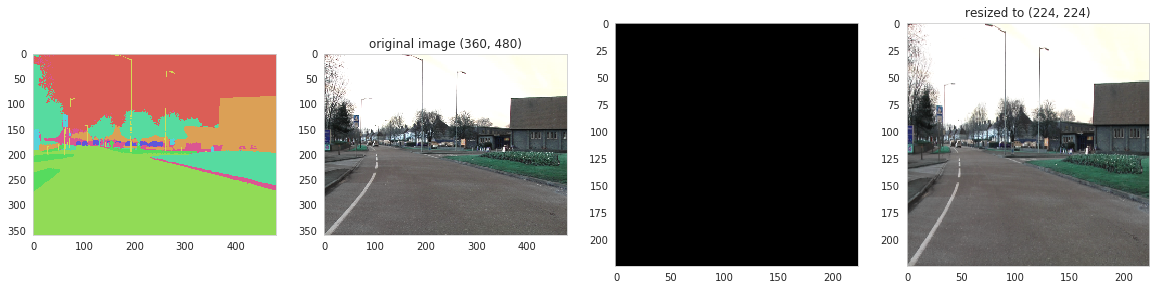

In [8]:
import random
def give_color_to_seg_img(seg, n_classes):
    '''
    seg : (input_width, input_height, 3)
    '''
    
    if (len(seg.shape) ==3):
        seg = seg[:,:,0]
        
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3)).astype('float')
    
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg==c)
        seg_img[:,:,0] += (segc*(colors[c][0]))
        seg_img[:,:,1] += (segc*(colors[c][1]))
        seg_img[:,:,2] += (segc*(colors[c][2]))
        
        
    return (seg_img)

input_height, input_width = 224, 224
output_height, output_width = 224, 224

ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg), 3, replace = False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png")   # (360, 480 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg, n_classes)
    
    fig = plt.figure(figsize=(20, 40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(cv2.resize(seg_img, (input_height, input_width))/ 255.0)
    
    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(cv2.resize(img_is, (output_height, output_width))/ 255.0)
    ax.set_title("resized to {}".format((output_height, output_width)))
    plt.show()
    
                    

In [9]:
def getImageArr(path, width, height):
    img = cv2.imread(path, 1)
    img = np.float32(cv2.resize(img, (width, height))) / 127.5 -1
    return img

def getSegmentationArr(path, nClasses, width, height):
    
    seg_labels = np.zeros((height, width, nClasses))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[:,:,0]
    
    for c in range(nClasses):
        
        seg_labels[:, :, c] = (img == c).astype(int)
    
    
    return seg_labels

In [15]:
images = os.listdir(dir_img)
images.sort()
segmentations = os.listdir(dir_seg)
segmentations.sort()

X = []
Y = []

for im, seg in zip(images, segmentations):
    X.append(getImageArr(dir_img + im, input_width, input_height))
    Y.append(getSegmentationArr(dir_seg + seg, n_classes , output_width, output_height))
    
X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)


(367, 224, 224, 3) (367, 224, 224, 12)


In [16]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd
warnings.filterwarnings("ignore")

#set_session(tf.Session(config = config))

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))


/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

python 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
keras version 2.2.4
tensorflow version 1.12.0


Using TensorFlow backend.


In [17]:
VGG_Weights_path = "vgg.h5"


In [18]:
def FCN8(nClasses, input_height = 224, input_width = 224):
    
    ##input_height and width must be divisible by 32 because maxpooling with filter size = (2,2) is operated
    #5 times which makes the input_height and width 2^5 = 32 times smaller
    
    assert input_height %32 ==0
    assert input_width%32 ==0
    IMAGE_ORDERING = "channels_last"
    
    img_input = Input(shape= (input_height, input_width, 3))   ## assume 224, 224, 3
    
    #Block 1
    x = Conv2D(64, (3,3),activation='relu', padding='same', name ='block_conv1', data_format= IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (3,3),activation='relu', padding='same', name ='block1_conv2',data_format= IMAGE_ORDERING)(x)
    x = MaxPool2D((2,2), strides=(2,2), name ='block1_pool', data_format=IMAGE_ORDERING)(x)
    
    f1 = x
    
    #block 2
    
    x = Conv2D(128, (3,3), activation='relu',padding='same',name ='block2_conv1',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3,3), activation='relu',padding='same',name ='block2_conv2',data_format=IMAGE_ORDERING)(x)
    x = MaxPool2D((2,2), strides=(2,2), name ='block2_pool', data_format=IMAGE_ORDERING)(x)
    f2= x
    
    #Block 3

     
    x = Conv2D(256, (3,3), activation='relu',padding='same',name ='block3_conv1',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3,3), activation='relu',padding='same',name ='block3_conv2',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3,3), activation='relu',padding='same',name ='block3_conv3',data_format=IMAGE_ORDERING)(x)
    x = MaxPool2D((2,2), strides=(2,2), name ='block3_pool', data_format=IMAGE_ORDERING)(x)
    pool3 = x
    
    #Block 4
    x = Conv2D(512, (3,3), activation='relu',padding='same',name ='block4_conv1',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3,3), activation='relu',padding='same',name ='block4_conv2',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3,3), activation='relu',padding='same',name ='block4_conv3',data_format=IMAGE_ORDERING)(x)
    x= MaxPool2D((2,2), strides=(2,2), name ='block4_pool', data_format=IMAGE_ORDERING)(x)
    pool4= x
    
    
    #Block 5
    x = Conv2D(512, (3,3), activation='relu',padding='same',name ='block5_conv1',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3,3), activation='relu',padding='same',name ='block5_conv2',data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3,3), activation='relu',padding='same',name ='block5_conv3',data_format=IMAGE_ORDERING)(x)
    x= MaxPool2D((2,2), strides=(2,2), name ='block5_pool', data_format=IMAGE_ORDERING)(x)
    pool5= x
    
    # assuming that the input_height = input_width = 224 as in VGG
    vgg = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path)  ##loading VGG for the encoder parts of FCNB
    
    n = 4096
    o = Conv2D(n, (7,7), activation='relu', padding = 'same', name ="conv6", data_format=IMAGE_ORDERING)(pool5)
    conv7 = Conv2D(n, (1,1), activation='relu', padding = 'same', name ="conv7", data_format=IMAGE_ORDERING)(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()
   
    
    
    
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block_conv1 (Conv2D)            (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block_conv1[0][0]                
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [19]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [ ]:
from keras import optimizers


sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=200,verbose=2)

Train on 311 samples, validate on 56 samples
Epoch 1/200


In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

In [37]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

NameError: name 'y_testi' is not defined

In [38]:
shape = (224,224)
n_classes= 10

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()

NameError: name 'y_predi' is not defined